In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torch
import torch.nn.functional as F
import pandas as pd
import torchvision
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchmetrics.classification import MulticlassConfusionMatrix, F1Score, MulticlassPrecision, MulticlassRecall, MulticlassPrecisionRecallCurve, MulticlassROC
from torch.optim import lr_scheduler
import torch.nn as nn
import torch
import pytorch_lightning as pl
from torch.utils.tensorboard import SummaryWriter
from matplotlib.backends.backend_agg import FigureCanvasAgg

import confinement_mode_classifier as cmc
import alt_models as am


In [2]:
signal_window = 320
num_workers = 32
signal_name = 'mc'
batch_size = 512
pl.seed_everything(42)
path=os.getcwd()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
shot_usage = pd.read_csv(f'{path}/data/shot_usage.csv')
shot_for_ris = shot_usage[shot_usage['used_for_alt']]
shot_numbers = shot_for_ris['shot']
shots_for_testing = shot_for_ris[shot_for_ris['used_as'] == 'test']['shot']
shots_for_validation = shot_for_ris[shot_for_ris['used_as'] == 'val']['shot']


Seed set to 42


In [3]:

shot_df, test_df, val_df, train_df = am.split_df(path, shot_numbers, shots_for_testing, shots_for_validation, use_ELMS=True, signal_name=signal_name)


# Create dataloaders
train_dataloader = am.get_dloader(train_df, batch_size=batch_size, 
                            balance_data=True, shuffle=False, 
                            signal_window=signal_window,
                            signal_name=signal_name,
                            num_workers=num_workers)

val_dataloader = am.get_dloader(val_df, batch_size=batch_size, 
                            balance_data=True, shuffle=False, 
                            signal_window=signal_window,
                            signal_name=signal_name,
                            num_workers=num_workers)

test_dataloader = am.get_dloader(test_df, batch_size=batch_size, 
                            balance_data=False, shuffle=False, 
                            signal_window=signal_window,
                            signal_name=signal_name,
                            num_workers=num_workers)

In [4]:
model = am.select_model_architecture('InceptionTime', num_classes=3, window=320)
model.load_state_dict(torch.load(f'/compass/Shared/Users/bogdanov/vyzkumny_ukol/runs/24-02-22, 18-31-57 InceptionTime_on_Mink_coil_320dpoints_16_epochs/model.pt'))
model.eval()

model.to(device)

Sequential(
  (0): Reshape()
  (1): InceptionBlock(
    (activation): ReLU()
    (inception_1): Inception(
      (conv_from_bottleneck_1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (conv_from_bottleneck_2): Conv1d(1, 32, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
      (conv_from_bottleneck_3): Conv1d(1, 32, kernel_size=(23,), stride=(1,), padding=(11,), bias=False)
      (max_pool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (conv_from_maxpool): Conv1d(1, 32, kernel_size=(1,), stride=(1,), bias=False)
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (inception_2): Inception(
      (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,), bias=False)
      (conv_from_bottleneck_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (conv_from_bottleneck_2): Conv1d(32, 32, kernel_siz

In [5]:


dummy_batch = torch.rand(32, 16).to(device)
dummy_target = torch.randint(0, 2, (32,))

In [6]:
lr = []
dummy_model = torch.nn.Sequential(torch.nn.Linear(16, 32),torch.nn.ReLU(32), torch.nn.Linear(32, 16),torch.nn.ReLU(16), torch.nn.Linear(16, 5), torch.nn.ReLU(5))
dummy_model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, total_steps=32)
for epoch in range(32):
    for i in range(100): #emulating 100 batches
        y_hat = dummy_model(torch.rand(32, 16).to(device))
        loss = F.cross_entropy(y_hat, torch.randint(0, 5, (32,)).to(device))
        optimizer.step()
        
    scheduler.step()
    lr.append(scheduler.get_last_lr())

In [8]:
loss

tensor(1.6140, device='cuda:0', grad_fn=<NllLossBackward0>)

In [7]:
y_hat

tensor([[0.0000, 0.0470, 0.0000, 0.0000, 0.2580],
        [0.0000, 0.0731, 0.0000, 0.0000, 0.1913],
        [0.0000, 0.0506, 0.0000, 0.0000, 0.1878],
        [0.0000, 0.0261, 0.0000, 0.0000, 0.2097],
        [0.0000, 0.0593, 0.0000, 0.0000, 0.1964],
        [0.0000, 0.0294, 0.0000, 0.0000, 0.1986],
        [0.0000, 0.0641, 0.0000, 0.0000, 0.2364],
        [0.0000, 0.0433, 0.0000, 0.0000, 0.2071],
        [0.0000, 0.0404, 0.0000, 0.0000, 0.2262],
        [0.0000, 0.0640, 0.0000, 0.0000, 0.2239],
        [0.0000, 0.0500, 0.0000, 0.0000, 0.1787],
        [0.0000, 0.0322, 0.0000, 0.0000, 0.1996],
        [0.0000, 0.0107, 0.0000, 0.0000, 0.2308],
        [0.0000, 0.0601, 0.0000, 0.0000, 0.2311],
        [0.0000, 0.0777, 0.0000, 0.0000, 0.1925],
        [0.0000, 0.0364, 0.0000, 0.0000, 0.2179],
        [0.0000, 0.0841, 0.0000, 0.0000, 0.2107],
        [0.0000, 0.0212, 0.0000, 0.0000, 0.2817],
        [0.0000, 0.0269, 0.0000, 0.0000, 0.1962],
        [0.0000, 0.0926, 0.0000, 0.0000, 0.2229],


In [70]:
len(train_dataloader)

4178

In [68]:
lr_unsqueezed = [x[0] for x in lr]``

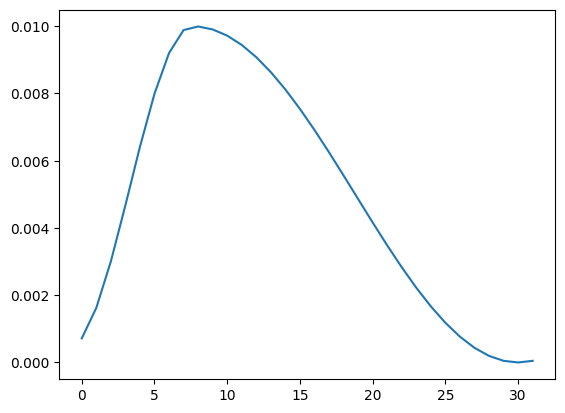

In [69]:
import matplotlib.pyplot as plt
plt.plot(lr_unsqueezed)

In [9]:
get_last_lr()

NameError: name 'get_last_lr' is not defined

In [15]:
from importlib import reload
reload(am)
reload(cmc)
metrics = am.test_model(f'{path}', model, test_dataloader, comment ='Testing visuals', signal_name=signal_name, writer=None)

Processing batches: 100%|██████████| 1832/1832 [06:49<00:00,  4.47it/s]


Processing metrics...
